# Model Training and Comparison

## Overview
This notebook trains multiple machine learning models and compares their performance on disease status prediction.

## Models Implemented:
1. Logistic Regression
2. Random Forest
3. Gradient Boosting
4. XGBoost
5. LightGBM
6. Support Vector Machine (SVM)
7. Naive Bayes
8. K-Nearest Neighbors
9. Decision Tree
10. Neural Network (MLP)

## Contents
1. Data Loading and Preparation
2. Feature Selection
3. Train-Test Split
4. Model Training
5. Cross-Validation
6. Model Comparison
7. Save Models

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import joblib
import os
from time import time

sys.path.append('scripts')

from model_training import (
    get_all_models, create_model_pipeline,
    perform_cross_validation
)
from model_evaluation import (
    evaluate_model, print_evaluation_report,
    compare_models
)
from visualization import (
    plot_target_distribution, plot_confusion_matrix,
    plot_roc_curves, plot_feature_importance
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

os.makedirs('output/models', exist_ok=True)

## 2. Load Processed Data

In [2]:
data = pd.read_csv('output/processed_data.csv')

print(f"Dataset shape: {data.shape}")
print(f"\nColumns: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())

Dataset shape: (2000, 43)

Columns: ['ID', 'admission_date', 'admission_time', 'discharge_date', 'discharge_time', 'hospital_ID', 'gender', 'age', 'disease_status', 'length_of_stay', 'admission_year', 'admission_month', 'admission_day_of_week', 'admission_quarter', 'Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma', 'Potassium plasma', 'Sodium plasma', 'Urea plasma', 'is_weekend_admission', 'is_winter', 'is_spring', 'is_summer', 'is_fall', 'lab_test_count', 'lab_mean_value', 'lab_std_value', 'lab_max_value', 'lab_min_value', 'lab_range', 'creatinine_high', 'sodium_low', 'sodium_high', 'sodium_abnormal', 'potassium_low', 'potassium_high', 'potassium_abnormal', 'urea_high', 'chloride_low', 'chloride_high', 'bicarbonate_low', 'bicarbonate_high']

First few rows:
     ID admission_date admission_time discharge_date discharge_time  \
0  1003     2002-04-25          07:47     2002-05-08          12:02   
1  1008     2004-09-02          07:49     2005-02-01          10:07   
2  1009

## 3. Prepare Features and Target

Total features: 37
Numerical features: 35
Categorical features: 2

Numerical features: ['age', 'length_of_stay', 'admission_year', 'admission_month', 'admission_day_of_week', 'admission_quarter', 'Bicarbonate plasma', 'Chloride plasma', 'Creatinine plasma', 'Potassium plasma']...

Categorical features: ['hospital_ID', 'gender']

X shape: (2000, 37)
y shape: (2000,)


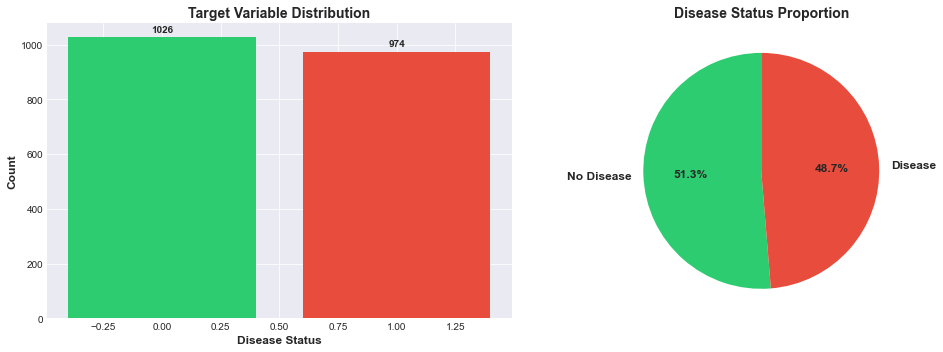

Class Distribution:
disease_status
0    1026
1     974
Name: count, dtype: int64
Class Ratio: 0.949


In [3]:
exclude_columns = [
    'ID', 'admission_date', 'discharge_date', 'admission_time',
    'discharge_time', 'disease_status'
]

feature_columns = [col for col in data.columns if col not in exclude_columns]

numerical_features = data[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"Total features: {len(feature_columns)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

print(f"\nNumerical features: {numerical_features[:10]}...")
print(f"\nCategorical features: {categorical_features}")

X = data[feature_columns]
y = data['disease_status']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
plot_target_distribution(y, title='Target Variable Distribution')

## 4. Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 1400 (70.0%)
Test set size: 600 (30.0%)

Training set class distribution:
disease_status
0    718
1    682
Name: count, dtype: int64

Test set class distribution:
disease_status
0    308
1    292
Name: count, dtype: int64


## 5. Initialize All Models

In [5]:
models = get_all_models(random_state=RANDOM_STATE)

print(f"Total models to train: {len(models)}")
print("\nModels:")
for i, (name, model) in enumerate(models.items(), 1):
    print(f"  {i}. {name}")

Total models to train: 9

Models:
  1. Logistic Regression
  2. Random Forest
  3. Gradient Boosting
  4. SVM
  5. Naive Bayes
  6. K-Nearest Neighbors
  7. Decision Tree
  8. Neural Network
  9. XGBoost


## 6. Train All Models and Evaluate

In [6]:
model_results = {}
trained_models = {}
training_times = {}

print("="*80)
print("TRAINING AND EVALUATING MODELS")
print("="*80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")

    pipeline = create_model_pipeline(model, numerical_features, categorical_features)

    start_time = time()
    pipeline.fit(X_train, y_train)
    training_time = time() - start_time
    training_times[model_name] = training_time

    print(f"Training time: {training_time:.2f} seconds")

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    try:
        y_pred_proba_train = pipeline.predict_proba(X_train)[:, 1]
        y_pred_proba_test = pipeline.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_pred_proba_train = None
        y_pred_proba_test = None

    train_results = evaluate_model(y_train, y_pred_train, y_pred_proba_train)
    test_results = evaluate_model(y_test, y_pred_test, y_pred_proba_test)

    model_results[model_name] = test_results
    trained_models[model_name] = pipeline

    print(f"\nTrain Accuracy: {train_results['accuracy']:.4f}")
    print(f"Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Train F1 Score: {train_results['f1_score']:.4f}")
    print(f"Test F1 Score: {test_results['f1_score']:.4f}")

    if y_pred_proba_test is not None:
        print(f"Test ROC AUC: {test_results['roc_auc']:.4f}")

print(f"\n{'='*80}")
print("ALL MODELS TRAINED SUCCESSFULLY")
print(f"{'='*80}")

TRAINING AND EVALUATING MODELS

Training: Logistic Regression
Training time: 0.03 seconds

Train Accuracy: 0.5607
Test Accuracy: 0.4800
Train F1 Score: 0.5521
Test F1 Score: 0.4602
Test ROC AUC: 0.4819

Training: Random Forest
Training time: 0.26 seconds

Train Accuracy: 0.8829
Test Accuracy: 0.5133
Train F1 Score: 0.8771
Test F1 Score: 0.4691
Test ROC AUC: 0.5063

Training: Gradient Boosting
Training time: 1.00 seconds

Train Accuracy: 0.9257
Test Accuracy: 0.5300
Train F1 Score: 0.9215
Test F1 Score: 0.4719
Test ROC AUC: 0.5276

Training: SVM
Training time: 0.95 seconds

Train Accuracy: 0.7336
Test Accuracy: 0.4883
Train F1 Score: 0.7271
Test F1 Score: 0.4805
Test ROC AUC: 0.5204

Training: Naive Bayes
Training time: 0.01 seconds

Train Accuracy: 0.5400
Test Accuracy: 0.5217
Train F1 Score: 0.4341
Test F1 Score: 0.4294
Test ROC AUC: 0.5010

Training: K-Nearest Neighbors
Training time: 0.01 seconds

Train Accuracy: 1.0000
Test Accuracy: 0.4783
Train F1 Score: 1.0000
Test F1 Score: 0.4

## 7. Cross-Validation Analysis

In [7]:
cv_results = {}

print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS (10-Fold)")
print("="*80)

for model_name, model in models.items():
    print(f"\nCross-validating: {model_name}")

    pipeline = create_model_pipeline(model, numerical_features, categorical_features)

    cv_result = perform_cross_validation(pipeline, X, y, cv=10, scoring='f1')
    cv_results[model_name] = cv_result

    print(f"  Mean F1 Score: {cv_result['mean']:.4f} (+/- {cv_result['std']:.4f})")
    print(f"  Range: [{cv_result['min']:.4f}, {cv_result['max']:.4f}]")

cv_comparison = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean F1': [cv_results[m]['mean'] for m in cv_results.keys()],
    'Std F1': [cv_results[m]['std'] for m in cv_results.keys()],
    'Min F1': [cv_results[m]['min'] for m in cv_results.keys()],
    'Max F1': [cv_results[m]['max'] for m in cv_results.keys()]
}).sort_values('Mean F1', ascending=False)

print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
print(cv_comparison.to_string(index=False))


CROSS-VALIDATION RESULTS (10-Fold)

Cross-validating: Logistic Regression
  Mean F1 Score: 0.4849 (+/- 0.0520)
  Range: [0.4091, 0.5520]

Cross-validating: Random Forest
  Mean F1 Score: 0.4781 (+/- 0.0293)
  Range: [0.4396, 0.5359]

Cross-validating: Gradient Boosting
  Mean F1 Score: 0.4584 (+/- 0.0363)
  Range: [0.4157, 0.5306]

Cross-validating: SVM
  Mean F1 Score: 0.4554 (+/- 0.0484)
  Range: [0.3793, 0.5392]

Cross-validating: Naive Bayes
  Mean F1 Score: 0.3618 (+/- 0.0596)
  Range: [0.2759, 0.4574]

Cross-validating: K-Nearest Neighbors
  Mean F1 Score: 0.4508 (+/- 0.0533)
  Range: [0.3511, 0.5258]

Cross-validating: Decision Tree
  Mean F1 Score: 0.4917 (+/- 0.0407)
  Range: [0.4167, 0.5600]

Cross-validating: Neural Network
  Mean F1 Score: 0.4002 (+/- 0.0712)
  Range: [0.2345, 0.4688]

Cross-validating: XGBoost
  Mean F1 Score: 0.4655 (+/- 0.0291)
  Range: [0.4153, 0.5054]

CROSS-VALIDATION SUMMARY
              Model  Mean F1   Std F1   Min F1   Max F1
      Decision Tree

## 8. Model Comparison

In [8]:
comparison_df = compare_models(model_results)

print("\n" + "="*80)
print("MODEL COMPARISON (Test Set Performance)")
print("="*80)
print(comparison_df.to_string(index=False))

comparison_df.to_csv('output/model_comparison.csv', index=False)
print("\nModel comparison saved to: output/model_comparison.csv")


MODEL COMPARISON (Test Set Performance)
              Model  Accuracy  Balanced Accuracy  Precision   Recall  Specificity  F1 Score  ROC AUC  Avg Precision
      Decision Tree  0.478333           0.479341   0.467492 0.517123     0.441558  0.491057 0.482054       0.486764
                SVM  0.488333           0.488281   0.474916 0.486301     0.490260  0.480541 0.520437       0.512095
  Gradient Boosting  0.530000           0.527442   0.520661 0.431507     0.623377  0.471910 0.527603       0.506535
      Random Forest  0.513333           0.511475   0.500000 0.441781     0.581169  0.469091 0.506327       0.486143
     Neural Network  0.481667           0.480986   0.466667 0.455479     0.506494  0.461005 0.489337       0.496474
Logistic Regression  0.480000           0.479363   0.465035 0.455479     0.503247  0.460208 0.481909       0.493295
K-Nearest Neighbors  0.478333           0.477384   0.462366 0.441781     0.512987  0.451839 0.479964       0.478869
            XGBoost  0.486667  

## 9. Visualize Model Comparison

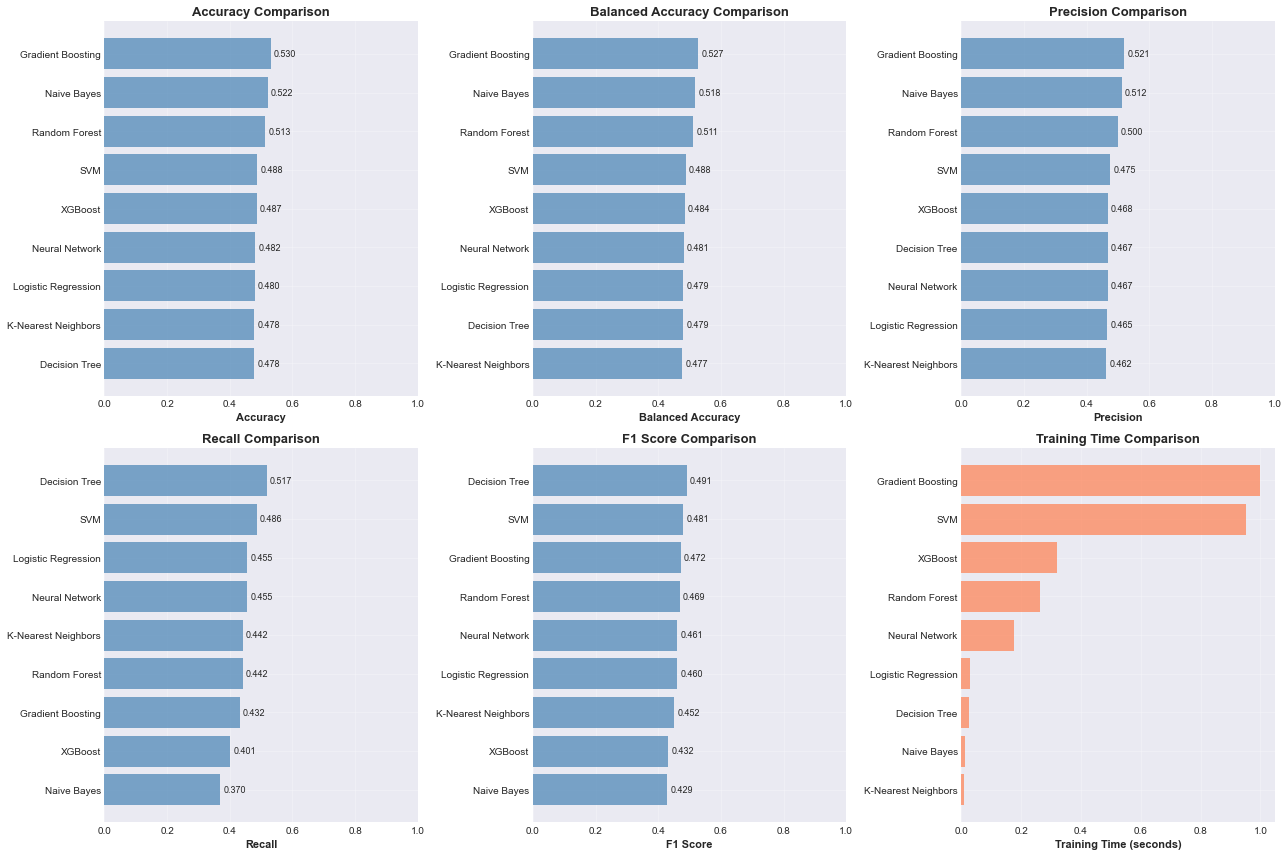

Model comparison visualization saved to: output/figures/model_comparison.png


In [9]:
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    sorted_data = comparison_df.sort_values(metric, ascending=True)

    ax.barh(sorted_data['Model'], sorted_data[metric], color='steelblue', alpha=0.7)
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(alpha=0.3)

    for i, v in enumerate(sorted_data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

training_time_df = pd.DataFrame({
    'Model': list(training_times.keys()),
    'Training Time (s)': list(training_times.values())
}).sort_values('Training Time (s)', ascending=True)

axes[5].barh(training_time_df['Model'], training_time_df['Training Time (s)'],
             color='coral', alpha=0.7)
axes[5].set_xlabel('Training Time (seconds)', fontsize=11, fontweight='bold')
axes[5].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
axes[5].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Model comparison visualization saved to: output/figures/model_comparison.png")

## 10. ROC Curves Comparison

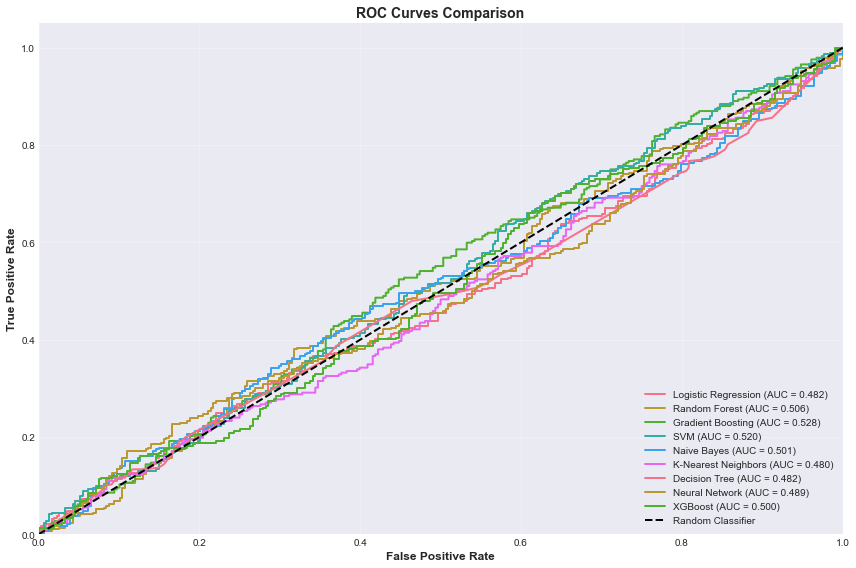

ROC curves saved to: output/figures/roc_curves.png


<Figure size 432x288 with 0 Axes>

In [10]:
roc_data = {}

for model_name in model_results.keys():
    results = model_results[model_name]
    if 'fpr' in results and 'tpr' in results:
        fpr = results['fpr']
        tpr = results['tpr']
        auc_score = results['roc_auc']
        roc_data[model_name] = (fpr, tpr, auc_score)

plot_roc_curves(roc_data, figsize=(12, 8))
plt.savefig('output/figures/roc_curves.png', dpi=300, bbox_inches='tight')
print("ROC curves saved to: output/figures/roc_curves.png")

## 11. Confusion Matrices for Top 3 Models

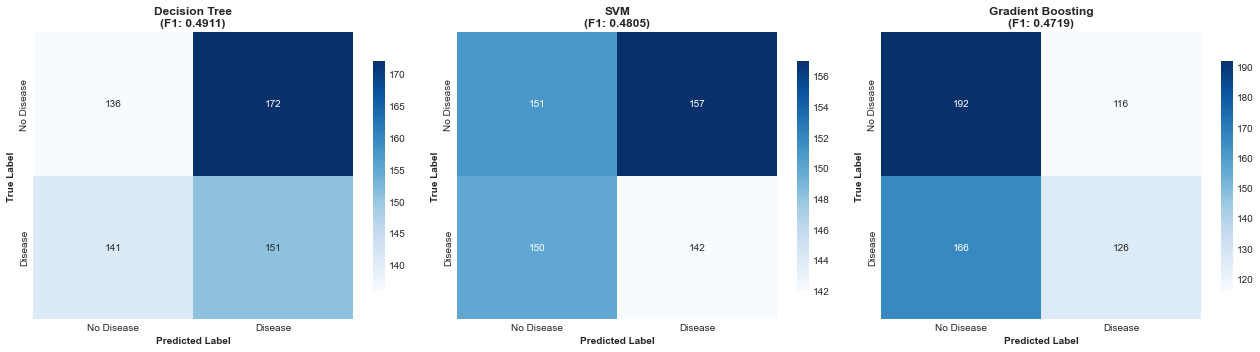

Confusion matrices saved to: output/figures/confusion_matrices_top3.png


In [11]:
top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    cm = model_results[model_name]['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'],
                ax=axes[idx], cbar_kws={"shrink": 0.8})
    axes[idx].set_title(f'{model_name}\n(F1: {comparison_df.iloc[idx]["F1 Score"]:.4f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('output/figures/confusion_matrices_top3.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices saved to: output/figures/confusion_matrices_top3.png")

## 12. Feature Importance (for tree-based models)


Feature Importance: Random Forest


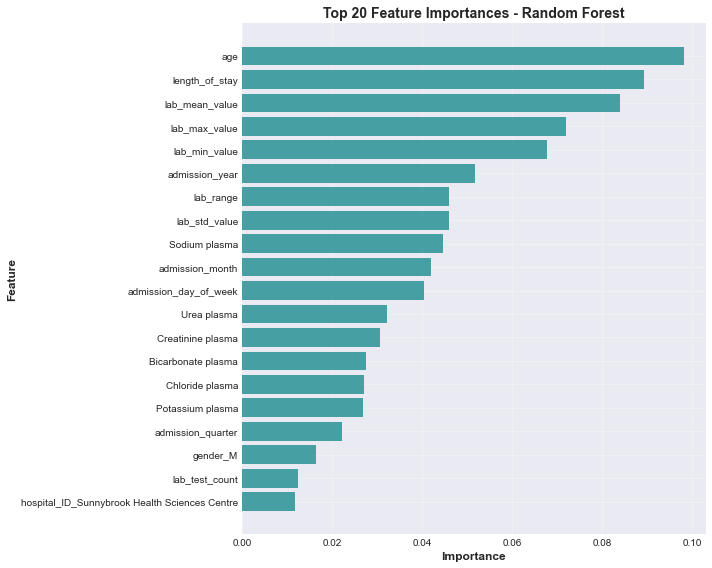

                                          feature  importance
0                                             age    0.098105
1                                  length_of_stay    0.089336
18                                 lab_mean_value    0.084065
20                                  lab_max_value    0.072038
21                                  lab_min_value    0.067844
2                                  admission_year    0.051725
22                                      lab_range    0.045929
19                                  lab_std_value    0.045922
10                                  Sodium plasma    0.044605
3                                 admission_month    0.042006
4                           admission_day_of_week    0.040573
11                                    Urea plasma    0.032264
8                               Creatinine plasma    0.030730
6                              Bicarbonate plasma    0.027475
7                                 Chloride plasma    0.027219
9       

<Figure size 432x288 with 0 Axes>

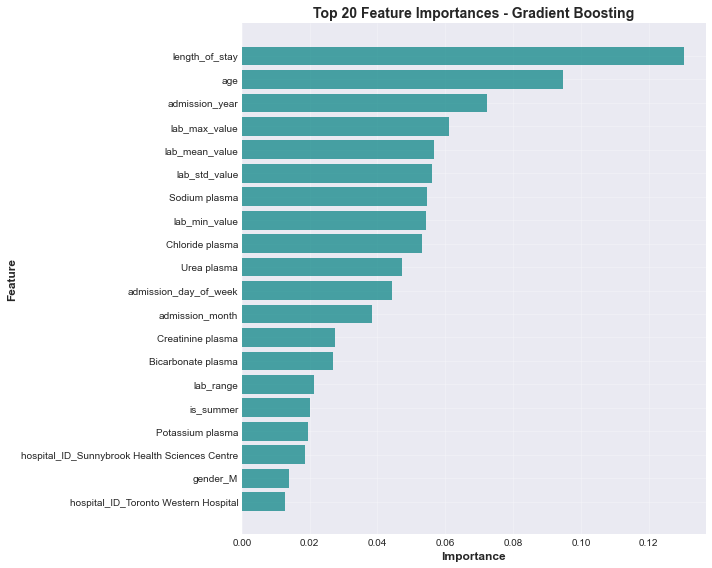

                                          feature  importance
1                                  length_of_stay    0.130296
0                                             age    0.094648
2                                  admission_year    0.072382
20                                  lab_max_value    0.061074
18                                 lab_mean_value    0.056607
19                                  lab_std_value    0.056107
10                                  Sodium plasma    0.054717
21                                  lab_min_value    0.054468
7                                 Chloride plasma    0.053195
11                                    Urea plasma    0.047162
4                           admission_day_of_week    0.044292
3                                 admission_month    0.038386
8                               Creatinine plasma    0.027413
6                              Bicarbonate plasma    0.026878
22                                      lab_range    0.021147
15      

<Figure size 432x288 with 0 Axes>

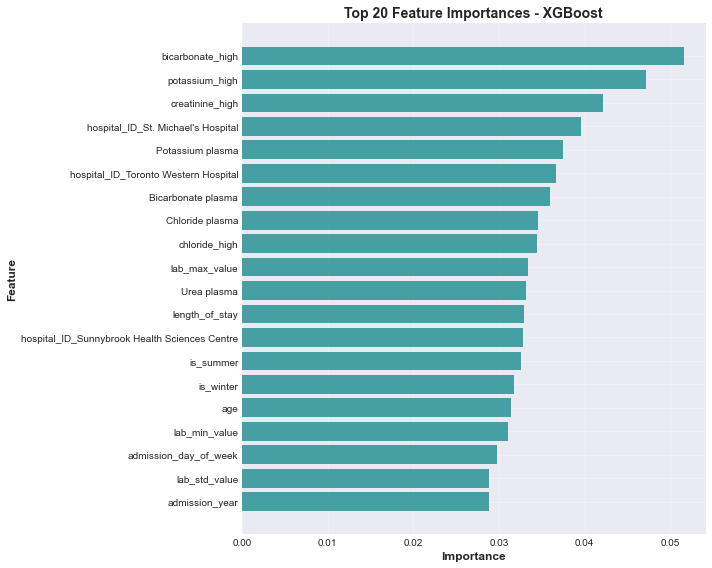

                                          feature  importance
34                               bicarbonate_high    0.051527
28                                 potassium_high    0.047133
23                                creatinine_high    0.042084
36             hospital_ID_St. Michael's Hospital    0.039592
9                                Potassium plasma    0.037427
38           hospital_ID_Toronto Western Hospital    0.036636
6                              Bicarbonate plasma    0.035933
7                                 Chloride plasma    0.034572
32                                  chloride_high    0.034420
20                                  lab_max_value    0.033422
11                                    Urea plasma    0.033154
1                                  length_of_stay    0.032880
37  hospital_ID_Sunnybrook Health Sciences Centre    0.032820
15                                      is_summer    0.032582
13                                      is_winter    0.031772
0       

<Figure size 432x288 with 0 Axes>

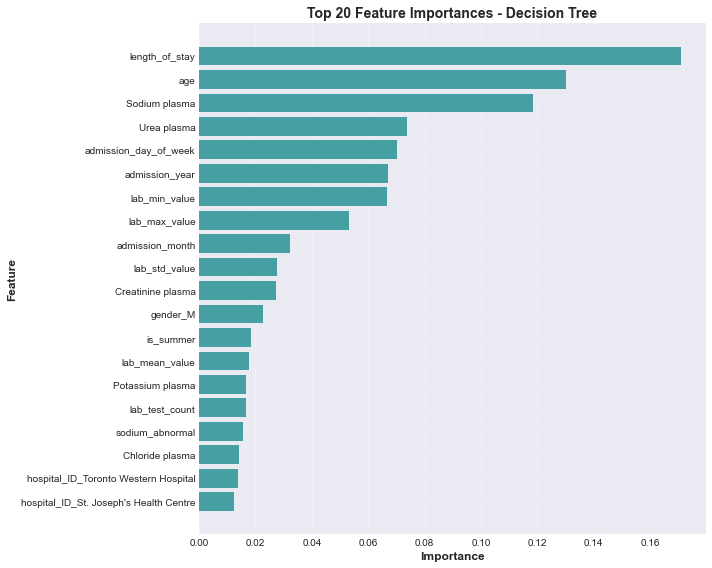

                                   feature  importance
1                           length_of_stay    0.171107
0                                      age    0.130228
10                           Sodium plasma    0.118473
11                             Urea plasma    0.073908
4                    admission_day_of_week    0.070033
2                           admission_year    0.066914
21                           lab_min_value    0.066727
20                           lab_max_value    0.053342
3                          admission_month    0.032113
19                           lab_std_value    0.027479
8                        Creatinine plasma    0.027378
39                                gender_M    0.022801
15                               is_summer    0.018592
18                          lab_mean_value    0.017780
9                         Potassium plasma    0.016780
17                          lab_test_count    0.016770
26                         sodium_abnormal    0.015514
7         

<Figure size 432x288 with 0 Axes>

In [12]:
tree_based_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'Decision Tree']

for model_name in tree_based_models:
    if model_name in trained_models:
        print(f"\n{'='*80}")
        print(f"Feature Importance: {model_name}")
        print(f"{'='*80}")

        pipeline = trained_models[model_name]
        classifier = pipeline.named_steps['classifier']

        if hasattr(classifier, 'feature_importances_'):
            preprocessor = pipeline.named_steps['preprocessor']

            cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
            all_feature_names = list(numerical_features) + list(cat_features)

            importances = classifier.feature_importances_

            importance_df = plot_feature_importance(
                all_feature_names,
                importances,
                top_n=20,
                title=f'Top 20 Feature Importances - {model_name}'
            )

            plt.savefig(f'output/figures/feature_importance_{model_name.replace(" ", "_").lower()}.png',
                       dpi=300, bbox_inches='tight')

            print(importance_df)

## 13. Save Trained Models

In [13]:
for model_name, pipeline in trained_models.items():
    filename = f'output/models/{model_name.replace(" ", "_").lower()}_model.pkl'
    joblib.dump(pipeline, filename)
    print(f"Saved: {filename}")

print("\nAll models saved successfully!")

Saved: output/models/logistic_regression_model.pkl
Saved: output/models/random_forest_model.pkl
Saved: output/models/gradient_boosting_model.pkl
Saved: output/models/svm_model.pkl
Saved: output/models/naive_bayes_model.pkl
Saved: output/models/k-nearest_neighbors_model.pkl
Saved: output/models/decision_tree_model.pkl
Saved: output/models/neural_network_model.pkl
Saved: output/models/xgboost_model.pkl

All models saved successfully!


## 14. Best Model Summary

In [14]:
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = model_results[best_model_name]

from model_evaluation import generate_model_summary

summary = generate_model_summary(best_model_results, best_model_name)
print(summary)

with open('output/best_model_summary.txt', 'w') as f:
    f.write(summary)

print("Best model summary saved to: output/best_model_summary.txt")


--------------------------------------------------------------------------------
MODEL SUMMARY: Decision Tree
--------------------------------------------------------------------------------

PERFORMANCE METRICS:
  • Accuracy: 47.83%
  • Balanced Accuracy: 47.93%
  • F1 Score: 49.11%
  • Precision (PPV): 46.75%
  • Recall (Sensitivity): 51.71%
  • Specificity: 44.16%

CLINICAL INTERPRETATION:
  • Positive Predictive Value: 46.75%
  • Negative Predictive Value: 49.10%
  • False Positive Rate: 55.84%
  • False Negative Rate: 48.29%

CONFUSION MATRIX:
                    Predicted: No Disease    Predicted: Disease
  Actual: No Disease           136                 172
  Actual: Disease              141                 151

--------------------------------------------------------------------------------

Best model summary saved to: output/best_model_summary.txt


## 15. Training Summary

In [15]:
print("="*80)
print("TRAINING SESSION SUMMARY")
print("="*80)

print(f"\nTotal models trained: {len(trained_models)}")
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_columns)}")
print(f"  - Numerical: {len(numerical_features)}")
print(f"  - Categorical: {len(categorical_features)}")

print(f"\nBest performing model: {best_model_name}")
print(f"Best F1 Score: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"Best Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")

total_training_time = sum(training_times.values())
print(f"\nTotal training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")

print("\nFiles saved:")
print("  - output/model_comparison.csv")
print("  - output/best_model_summary.txt")
print("  - output/models/*.pkl (trained models)")
print("  - output/figures/*.png (visualizations)")

print("\n" + "="*80)
print("Model training and comparison complete!")
print("="*80)

TRAINING SESSION SUMMARY

Total models trained: 9
Training set size: 1400
Test set size: 600
Number of features: 37
  - Numerical: 35
  - Categorical: 2

Best performing model: Decision Tree
Best F1 Score: 0.4911
Best Accuracy: 0.4783

Total training time: 2.79 seconds (0.05 minutes)

Files saved:
  - output/model_comparison.csv
  - output/best_model_summary.txt
  - output/models/*.pkl (trained models)
  - output/figures/*.png (visualizations)

Model training and comparison complete!
